In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp 
from jax import grad, hessian, jacfwd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 

# disable LaTeX rendering
plt.rcParams['text.usetex'] = False

x1 = λr (x[...,0])
x2 = V0 (x[...,1])
x3 = D (x[...,2])
x4 = cl_cd (x[...,3])

In [2]:
# define wind power function
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

g = 9.81 # gravitational acceleration (m*s^-2)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3])

bounds = Bounds([5.0, 0.0, 120.0, 25.0], [10.0, 22.0, 145.0, 100.0])

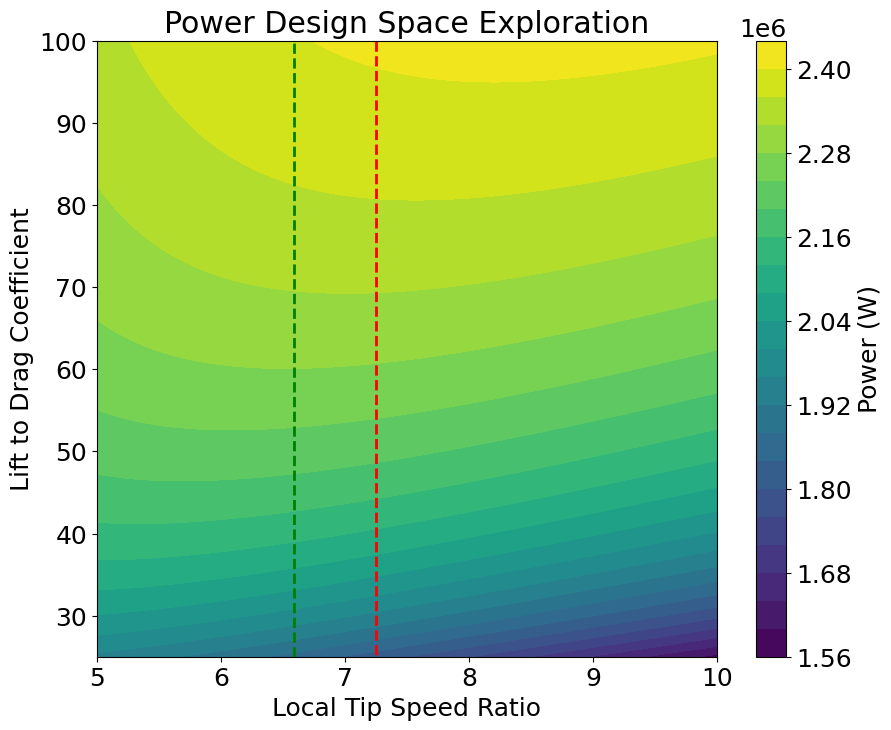

In [12]:
# let us fix x[1] (V0) and x[2] (D) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return (np.pi/8)*CP*rho*(22)**2*(145)**2

# create meshgrid 
x0_range = np.linspace(5.0, 10.0, 100)
x3_range = np.linspace(25.0, 100.0, 100)
X0, X3 = np.meshgrid(x0_range, x3_range)
X1 = 22
X2 = 145

X = np.stack((X0, np.full_like(X0, 22), np.full_like(X0, 145), X3), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * 22 / 145
c3 = lambda x: 0.5 - 2 * 22**2 / (g * x[3])

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X3, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Lift to Drag Coefficient')
plt.title('Power Design Space Exploration')

# plot constraints
plt.contour(X0, X3, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X3, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X3, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') # out of range anyways

# feasible region is right of red, left of green
plt.show()


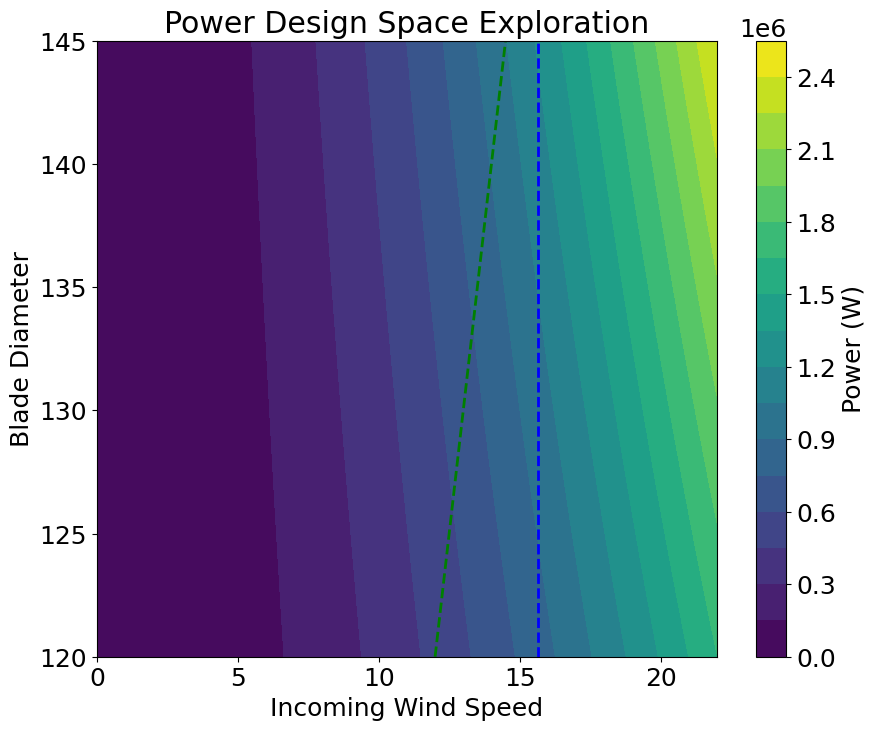

In [13]:
# let us fix x[0] (λr) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(10)*(10+(1.32+((10-8)/20)**2)/(beta**(2/3)))**-1-0.57*10**2/((100)*((10)+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# create meshgrid
x1_range = np.linspace(0.0, 22.0, 100)
x2_range = np.linspace(120.0, 145.0, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

X = np.stack((np.full_like(X1, 10),X1, X2,np.full_like(X2, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232) * (1-(1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232)))
c2 = lambda x: 2.0 - 2 * 10 * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Incoming Wind Speed')
plt.ylabel('Blade Diameter')
plt.title('Power Design Space Exploration')


# plot constraints
#plt.contour(X1, X2, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--') # only dependent on X0
plt.contour(X1, X2, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X1, X2, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') 

plt.show()


# feasible region is to lef

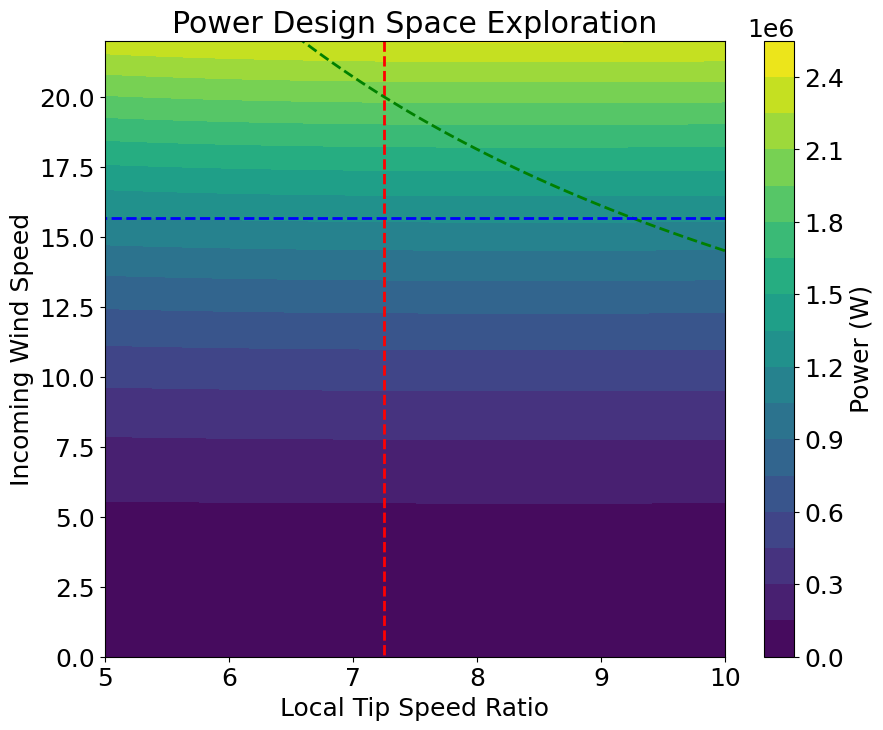

In [14]:
# let us fix x[2] (D) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

# create meshgrid
x0_range = np.linspace(5.0, 10.0, 1000)
x1_range = np.linspace(0.0, 22.0, 1000)
X0, X1 = np.meshgrid(x0_range, x1_range)


X = np.stack((X0, X1, np.full_like(X0, 145), np.full_like(X1, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / 145
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)


# create contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X1, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Power Design Space Exploration')


# plot constraints
plt.contour(X0, X1, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X1, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X1, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--')

# feasible region is below blue, below green, and to right of red
plt.show()


In [106]:
# define constraints for SciPy minimize
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2


ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k = 0

# define a callback function to store optimization histories
def callback_tr(x, state):
    global k
    k += 1
    
    xx_tr.append(x) # iterate xk
    fx_tr.append(-1*state.fun) # function value
    c1x_tr.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_tr.append(ineq_con2['fun'](x))
    c3x_tr.append(ineq_con3['fun'](x))
    
    constraint_vec_tr = [c1(x), c2(x), c3(x)]
    constraint_history_tr.append(constraint_vec_tr)
    
    print(f'xk_tr {x}, fk_tr {-1*state.fun}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')
    
# starting point
x0 = np.array([7.0, 18.0, 120.0, 25.0])

xx_tr = [] 
fx_tr = []
c1x_tr = [] 
c2x_tr = [] 
c3x_tr = [] 
constraint_history_tr = []

res = minimize(power, x0, method='trust-constr', jac=None,
               constraints=[ineq_con1, ineq_con2, ineq_con3],
               options=None,
               bounds=bounds, callback=callback_tr)

# determining MCV 

MCV_tr = []

for constraint_vec_tr in constraint_history_tr:
    new_constraint_vec_tr = [
        max(0, -constraint_vec_tr[0]),  
        max(0, -constraint_vec_tr[1]),    
        max(0, -constraint_vec_tr[2])  
    ]
    c_inf_tr = np.linalg.norm(new_constraint_vec_tr, ord=np.inf)
    
    MCV_tr.append(c_inf_tr)

xk_tr [  7.  18. 120.  25.], fk_tr 842707.7632166761, c1 -0.0005480279996398219, c2 0.26206896551724146, c3 -0.16055045871559637
xk_tr [  6.78721852  18.48975258 120.21236377  25.21148103], fk_tr 902525.7145178497, c1 -0.0009728641829838125, c2 0.26904839825231486, c3 -0.19698460841200705
xk_tr [  5.64513872  22.12431481 120.59561887  25.58171587], fk_tr 1353933.2447355601, c1 -0.00261913675130121, c2 0.27731274256172256, c3 -0.4979313060315097
xk_tr [  4.80033302  19.39716761 121.41728562  26.18479261], fk_tr 1078875.5673394124, c1 -0.0032001890420836343, c2 0.7156846326222206, c3 -0.26707464111712786
xk_tr [  4.90046264  17.7504493  123.73690233  27.60221885], fk_tr 949167.0956202111, c1 -0.003159000785174726, c2 0.8002011918840315, c3 -0.1423617745024811
xk_tr [  4.95278904  16.80091356 126.576957    28.8437252 ], fk_tr 898398.4959226763, c1 -0.003134490386902722, c2 0.8522568203848144, c3 -0.0754754259608581
xk_tr [  4.97763357  16.28417209 144.90050446  37.63623087], fk_tr 1164362

In [107]:
# COBYLA

# turn equality constraints to inequality constraints for COBYLA method

ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con2 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k_c = 0  
# define a callback function to store optimization histories
def callback_c(x):
    global k_c
    k_c += 1
    
    xx_c.append(x) # iterate xk
    fk_c_value = power(x)
    fx_c.append(-1*fk_c_value) # function value
    c1x_c.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_c.append(ineq_con2['fun'](x))
    c3x_c.append(ineq_con3['fun'](x))
    
    constraint_vec_c = [c1(x), c2(x), c3(x)]
    constraint_history_c.append(constraint_vec_c)
    
    print(f'xk_c {x}, fk_c {-1*fk_c_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')

# starting point
x0 = np.array([7.0, 18.0, 120.0, 25.0])

xx_c = [] 
fx_c = []
c1x_c = [] 
c2x_c = [] 
c3x_c = [] 
constraint_history_c = []

constraints=[ineq_con1, ineq_con2, ineq_con3]

res = minimize(power, x0, method='COBYLA', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_c)    

# determining MCV 

MCV_c = []

for constraint_vec_c in constraint_history_c:
    new_constraint_vec_c = [
        max(0, -constraint_vec_c[0]),  
        max(0, -constraint_vec_c[1]),  
        max(0, -constraint_vec_c[2])
    ]
    
    c_inf_c = np.linalg.norm(new_constraint_vec_c, ord=np.inf)
    
    MCV_c.append(c_inf_c)    

xk_c [  8.  18. 120.  25.], fk_c 807818.0708131696, c1 0.0020238960025599217, c2 0.01379310344827589, c3 -0.16055045871559637
xk_c [  7.  19. 120.  25.], fk_c 938942.9090161113, c1 -0.0005480279996398219, c2 0.16551724137931045, c3 -0.2359836901121305
xk_c [  7.  19. 121.  25.], fk_c 954657.1618683948, c1 -0.0005480279996398219, c2 0.16551724137931045, c3 -0.2359836901121305
xk_c [  7.  19. 121.  26.], fk_c 969726.4761126906, c1 -0.0005480279996398219, c2 0.16551724137931045, c3 -0.2359836901121305
xk_c [  7.  17. 120.  25.], fk_c 751674.5171901834, c1 -0.0005480279996398219, c2 0.35862068965517246, c3 -0.08919469928644241
xk_c [  7.          16.00015804 119.98222227  25.        ], fk_c 665659.0488241636, c1 -0.0005480279996398219, c2 0.4551571551156226, c3 -0.02192672209307811
xk_c [  7.21308095  15.54846164 120.56916815  25.63722948], fk_c 636134.7695351236, c1 -8.196450142405887e-05, c2 0.45307155271045696, c3 0.007126076434192774
xk_c [  7.26505511  15.54553963 121.48332237  26.039

In [108]:
# SLSQP

k_slsqp = 0  
# define a callback function to store optimization histories
def callback_slsqp(x):
    global k_slsqp
    k_slsqp += 1
    
    xx_slsqp.append(x) # iterate xk
    fk_slsqp_value = power(x)
    fx_slsqp.append(-1*fk_slsqp_value) # function value
    c1x_slsqp.append(ineq_con1['fun'](x)) 
    c2x_slsqp.append(ineq_con2['fun'](x))
    c3x_slsqp.append(ineq_con3['fun'](x))
    
    constraint_vec_slsqp = [c1(x), c2(x), c3(x)]
    constraint_history_slsqp.append(constraint_vec_slsqp)
    
    print(f'k_s {k_slsqp}, xk_slsqp {x}, fk_slsqp {-1*fk_slsqp_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')


x0 = np.array([7.0, 18.0, 120.0, 25.0])

xx_slsqp = [] 
fx_slsqp = []
c1x_slsqp = [] 
c2x_slsqp = [] 
c3x_slsqp = [] 
constraint_history_slsqp = []
constraints=[ineq_con1, ineq_con2, ineq_con3]

res = minimize(power, x0, method='SLSQP', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_slsqp)

# determining MCV

MCV_slsqp = []

for constraint_vec_slsqp in constraint_history_slsqp:
    new_constraint_vec_slsqp = [
        max(0, -constraint_vec_slsqp[0]),  
        max(0, -constraint_vec_slsqp[1]),  
        max(0, -constraint_vec_slsqp[2])
    ]
    
    c_inf_slsqp = np.linalg.norm(new_constraint_vec_slsqp, ord=np.inf)
    
    MCV_slsqp.append(c_inf_slsqp)

k_s 1, xk_slsqp [  7.29626963  15.71442784 144.98531569  99.98558897], fk_slsqp 1227832.1572756036, c1 0.00011141567607697578, c2 0.4185282402829882, c3 -0.003452074263366578
k_s 2, xk_slsqp [ 10.          16.25806519 145.         100.        ], fk_slsqp 1313113.8273056804, c1 0.010877759999999959, c2 -0.24249175071736317, c3 -0.03888824426118653
k_s 3, xk_slsqp [  8.63246082  16.48064599 145.         100.        ], fk_slsqp 1353429.0307697668, c1 0.00421553660337759, c2 0.03767543717804456, c3 -0.053744530631025245
k_s 4, xk_slsqp [  8.68938395  16.29641267 145.         100.        ], fk_slsqp 1323286.5960886062, c1 0.0044373735925063995, c2 0.046816735521650665, c3 -0.04143336551828214
k_s 5, xk_slsqp [  8.68243527  16.36154091 145.         100.        ], fk_slsqp 1333891.742109506, c1 0.004410063443394341, c2 0.040579037443803756, c3 -0.0457696654378017
k_s 6, xk_slsqp [  8.31395889  15.80492418 145.         100.        ], fk_slsqp 1244790.0053710607, c1 0.003051152651295186, c2 0.1

# plot contours for opt. trajectory
m =50
xv, yv = np.meshgrid(np.linspace(5,10, m), np.linspace(0,22,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))


def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

y = power(x)

plt.figure(figsize=(8,8))
plt.contour(xv, yv, y.reshape(m,m), levels=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# plot trust-region algorithm
x1_tr = [x[0] for x in xx_tr]
x2_tr = [x[1] for x in xx_tr]

# plot COBYLA algorithm
x1_c = [x[0] for x in xx_c]
x2_c = [x[1] for x in xx_c]

# plot SLSQP algorithm
x1_slsqp = [x[0] for x in xx_slsqp]
x2_slsqp = [x[1] for x in xx_slsqp]

plt.plot(x1_tr, x2_tr, marker='o', c='#2c5fb8', label='Trust-Region Constrained')
plt.plot(x1_c, x2_c, marker='o', c='#F57E10', label='COBYLA')
plt.plot(x1_slsqp, x2_slsqp, marker='o', c='g', label='SLSQP')

x1 = np.linspace(5.0, 10.0, 1000)
x2 = np.linspace(0.0, 22.0, 1000)
x1v, x2v = np.meshgrid(x1, x2)
x = np.column_stack((x1v.reshape(-1,1), x2v.reshape(-1,1)))

plt.contour(x1v, x2v, c1([x1v, x2v]), levels=[0], colors='k', linestyles='--')
plt.contour(x1v, x2v, c2([x1v, x2v]), levels=[0], colors='k', linestyles='--')


plt.title('Optimization Trajectory')
plt.legend(fontsize='9')
plt.show()

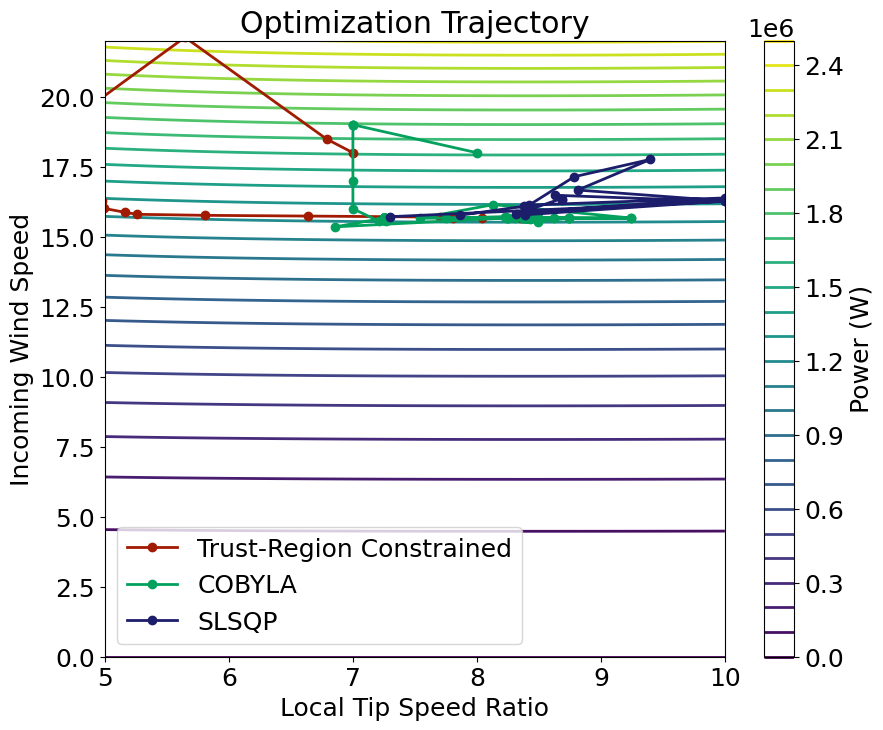

In [109]:
# Optimization Trajectory

plt.figure(figsize=(10, 8))
contour = plt.contour(X0, X1, -1*power(X), 25, cmap='viridis')
plt.colorbar(contour, label='Power (W)')

# plot trust-region algorithm
x1_tr = [x[0] for x in xx_tr]
x2_tr = [x[1] for x in xx_tr]

# plot COBYLA algorithm
x1_c = [x[0] for x in xx_c]
x2_c = [x[1] for x in xx_c]

# plot SLSQP algorithm
x1_slsqp = [x[0] for x in xx_slsqp]
x2_slsqp = [x[1] for x in xx_slsqp]

plt.plot(x1_tr, x2_tr, marker='o', c='#a11b03', label='Trust-Region Constrained')
plt.plot(x1_c, x2_c, marker='o', c='#03a15d', label='COBYLA')
plt.plot(x1_slsqp, x2_slsqp, marker='o', c='#1c1d6b', label='SLSQP')


plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Optimization Trajectory')
plt.xlim(5.0, 10.0)  
plt.ylim(0, 22.0)
plt.legend()
plt.show()



<Figure size 1000x800 with 0 Axes>

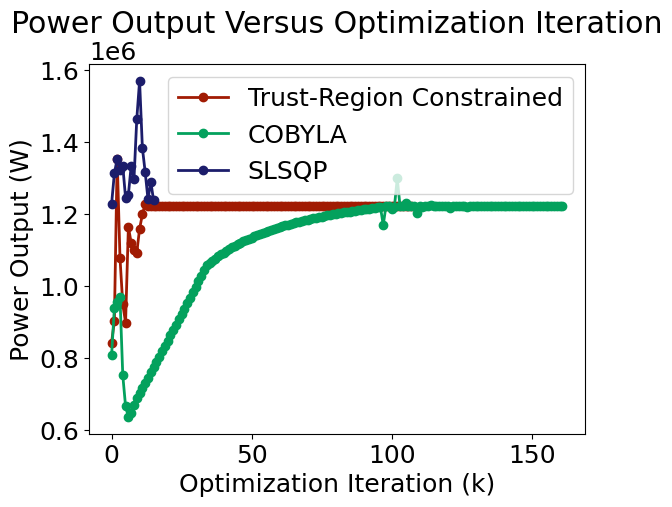

In [110]:
# Function Value vs. Optimization Iteration

plt.figure(figsize=(10, 8))
plt.figure()
plt.plot(range(len(fx_tr)), fx_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(fx_c)), fx_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(fx_slsqp)), fx_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Power Output (W)')
plt.title('Power Output Versus Optimization Iteration')
plt.legend()
plt.show()



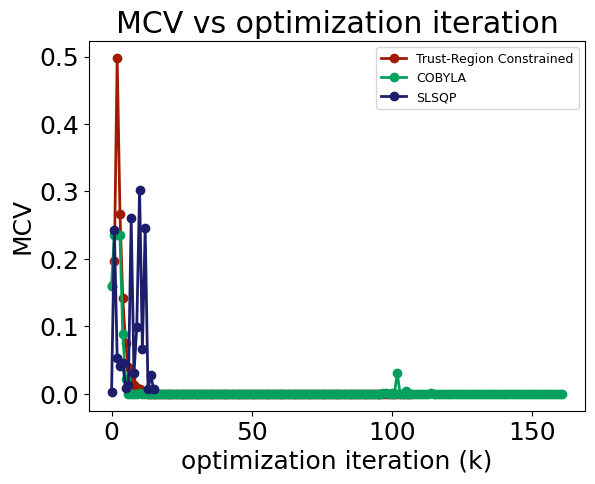

In [111]:
# Maximum Constraint Violation

plt.plot(range(len(c1x_tr)), MCV_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(c1x_c)), MCV_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(c1x_slsqp)), MCV_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('optimization iteration (k)')
plt.ylabel('MCV')
plt.title('MCV vs optimization iteration')
plt.legend(fontsize='9')
plt.show()